In [12]:
import scipy.signal
import torch
from src.utils.fourier import dft, idft
import matplotlib.pyplot as plt
import scipy
import numpy as np
# from src.utils.filters import MovingAvg
from src.utils.fourier import sphere2complex, complex2sphere

# def moving_average_freq_response(N, sample_rate, freq):
#     omega = 2 * torch.pi * freq / sample_rate
#     # SMA coefficients
#     b = np.ones(N)
#     a = np.array([N] + [0]*(N-1))

#     # Calculate the frequency response
#     w, h = scipy.signal.freqz(b, a, worN=omega)
#     # w *= sample_rate / (2 * np.pi)                      # Convert from rad/sample to Hz
#     return h

def moving_average_freq_response(N, sample_rate, freq):
    omega = 2 * torch.pi * freq / sample_rate
    coeff = torch.exp(-1j * omega * (N - 1) / 2) / N
    omega = torch.where(omega == 0, 1e-5, omega)
    Hw = coeff * torch.sin(omega * N / 2) / torch.sin(omega / 2)
    return Hw

# def moving_avg(x, N):
#     avg = torch.nn.AvgPool1d(kernel_size=N, stride=1)
#     front = x[:, 0:1, :].repeat(1, N // 2, 1)
#     end = x[:, -1:, :].repeat(1, N - 1 - N // 2, 1)
#     x = torch.cat([front, x, end], dim=1)
#     x = avg(x.permute(0, 2, 1))
#     x = x.permute(0, 2, 1)
#     return x



original signal

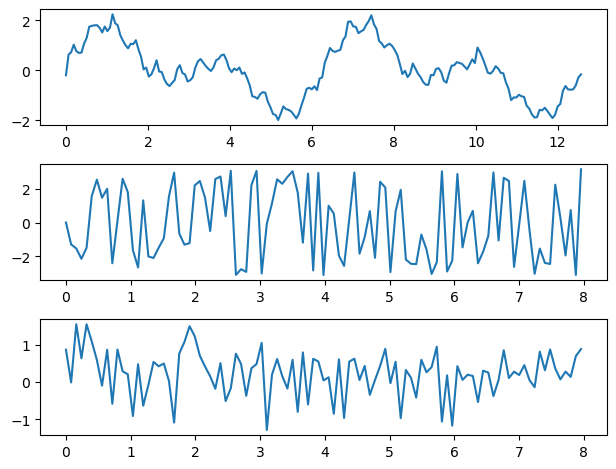

In [21]:
t = torch.linspace(0, 4*torch.pi, 200)
sample_rate = len(t)/(t.max()-t.min())
x = torch.sin(t) + torch.sin(2*t) + 0.3*torch.sin(12*t) + 0.1*torch.randn(t.shape)
x_freq = torch.fft.rfft(x)
theta, phi = complex2sphere(x_freq.real, x_freq.imag)

freq = torch.fft.rfftfreq(len(t), 1/sample_rate)
mag = x_freq.abs()
phase = x_freq.angle()
phase[torch.abs(phase) < 1] = 0
fig, axs = plt.subplots(3)
axs[0].plot(t, x)
# axs[1].plot(freq, x_freq.real)
# axs[2].plot(freq, x_freq.imag)
axs[1].plot(freq, theta)
axs[2].plot(freq, phi)
fig.tight_layout()

manuplate on the frequency domain

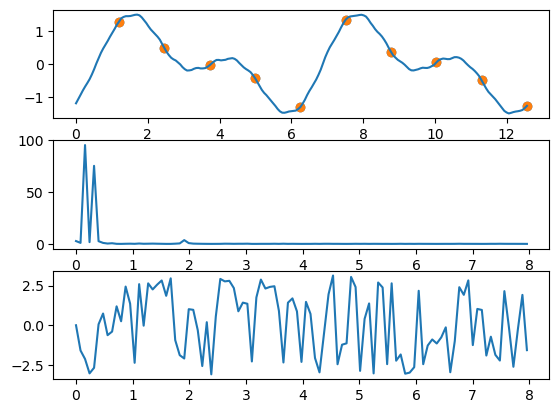

In [22]:
N = 20
h = moving_average_freq_response(N, sample_rate=sample_rate, freq=freq)
x_freq_new = x_freq * h
mag = x_freq_new.abs()
phase = x_freq_new.angle()
x_new = torch.fft.irfft(x_freq_new)
x_new_avgpool = torch.nn.functional.avg_pool1d(x.reshape(1,1,-1), N,N).permute(0,2,1)
fig, axs = plt.subplots(3)
# axs[0].plot(x_new)
axs[0].plot(t, x_new)
axs[0].scatter(t[N-1::N], x_new[N-1::N])
axs[0].scatter(t[N-1::N], x_new_avgpool.flatten())
axs[1].plot(freq, mag)
axs[2].plot(freq, phase)

manuplate on the time domain

In [14]:
from src.utils.filters import MovingAvgTime


x_new = MovingAvgTime(x.reshape(1, -1, 1), N).flatten()
# x_new = np.convolve(np.concatenate([x[-N+1:],x]), np.ones(N)/N, mode='valid')
x_freq = torch.fft.rfft(x_new)
freq = torch.fft.rfftfreq(len(t), 1/sample_rate)
mag = x_freq.abs()
phase = x_freq.angle()

# mag = x_freq_new.abs()
# phase = x_freq_new.angle()
# # print(phase)
# x = torch.fft.irfft(x_freq_new)
print(x_new[N//2:-N//2])
fig, axs = plt.subplots(3)
axs[0].plot(x_new[N//2:-N//2])
# axs[1].plot(freq, mag)
# axs[2].plot(freq, phase)

AttributeError: 'MovingAvgTime' object has no attribute 'flatten'

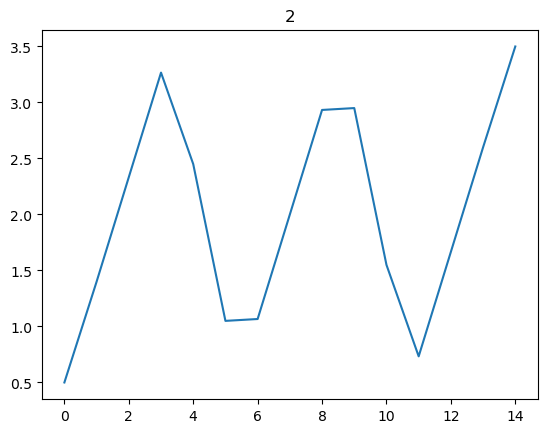

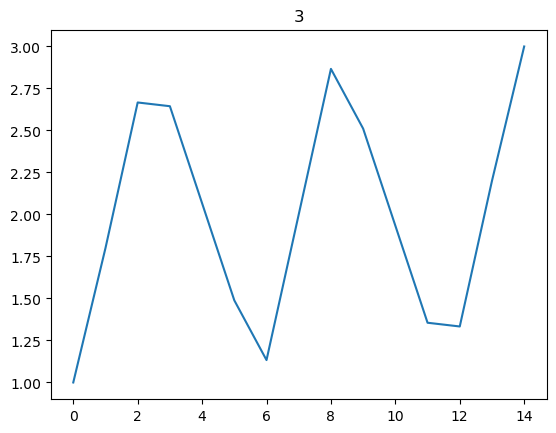

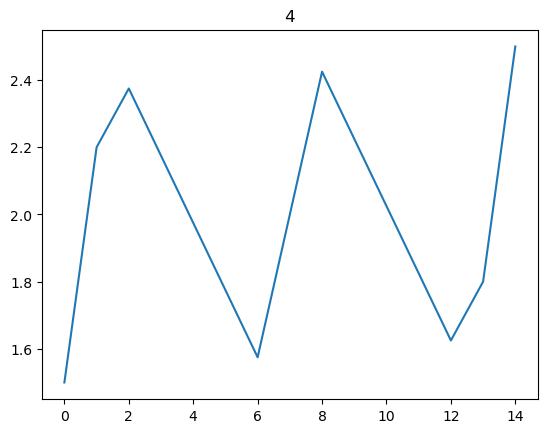

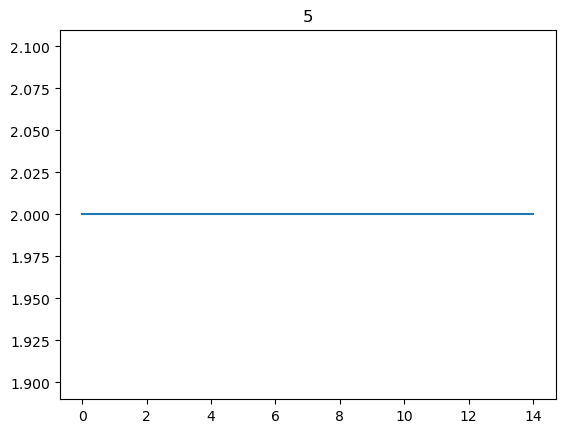

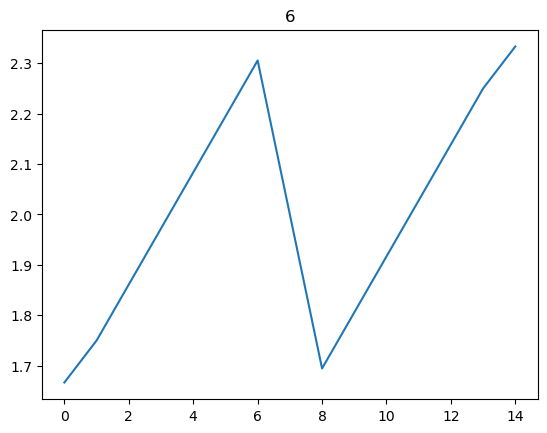

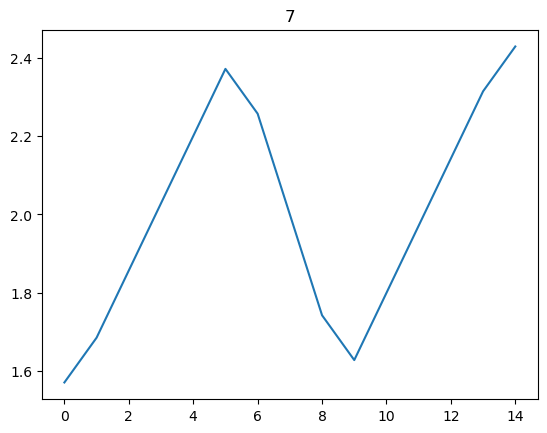

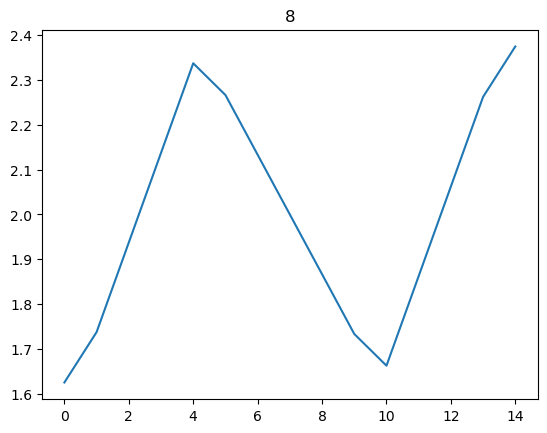

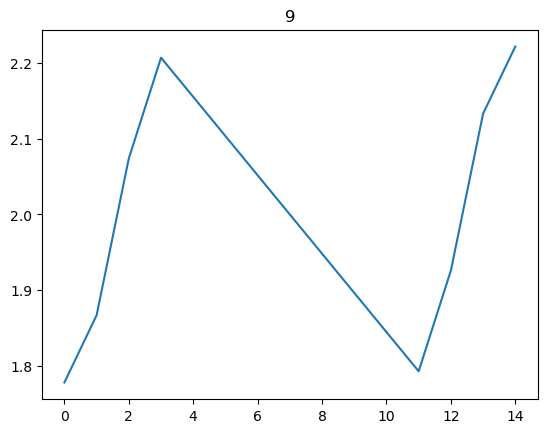

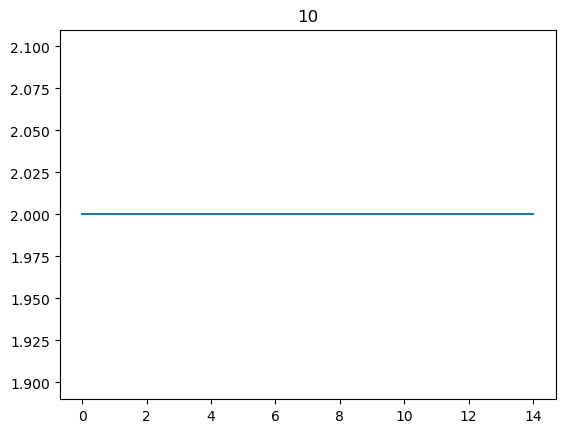

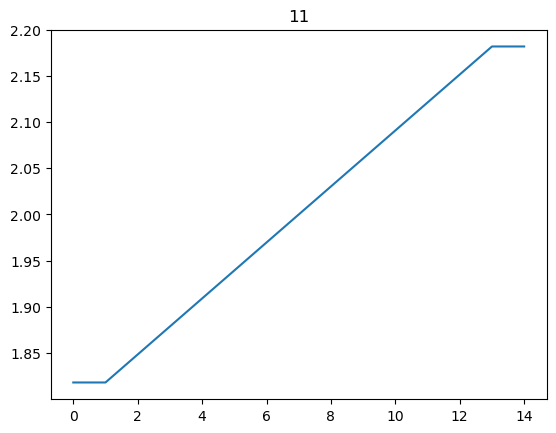

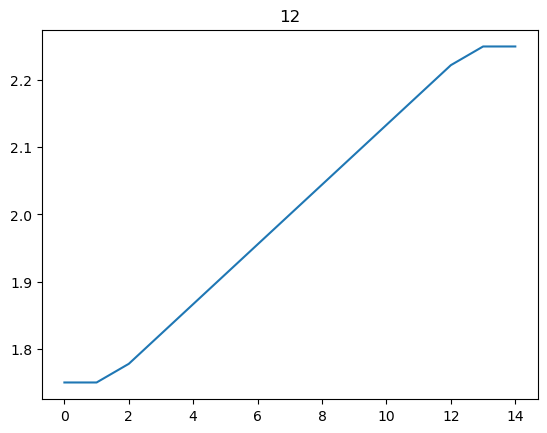

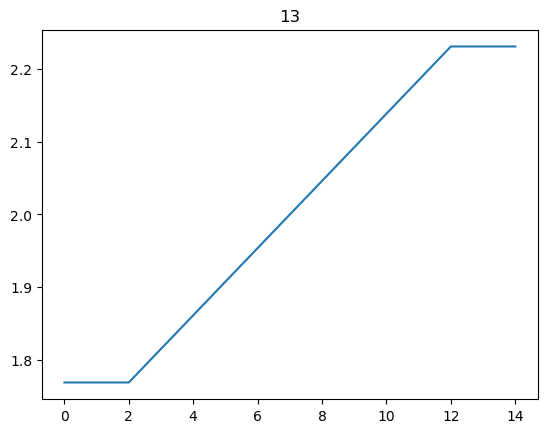

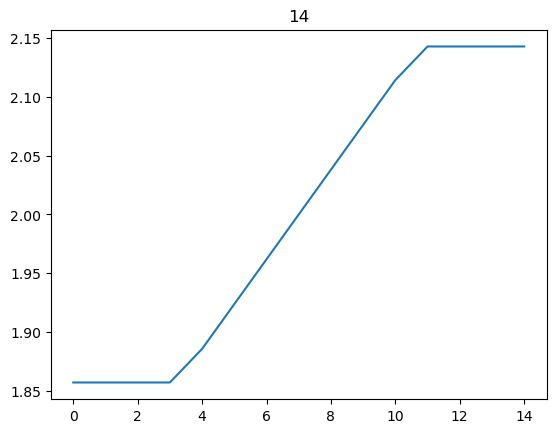

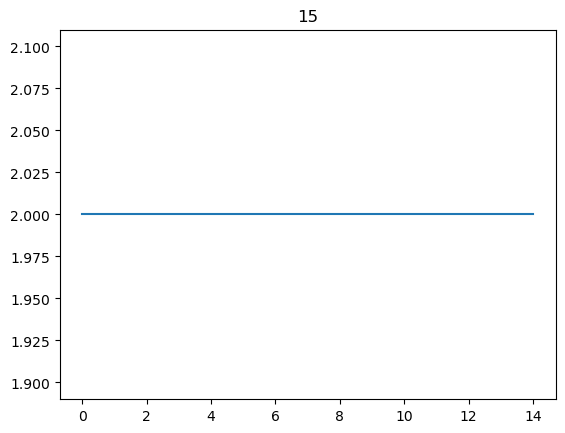

In [2]:
import torch
from src.models.diffusion import MovingAvgDiffusion
from src.models.backbone import MLPBackbone
from src.utils.filters import get_factors, MovingAvgTime
import matplotlib.pyplot as plt

seq_len = 800
# bb = MLPBackbone(1,seq_len,10,1)
# m = MovingAvgDiffusion(backbone=bb)


# t = torch.linspace(0, 8*torch.pi, seq_len)
# sample_rate = len(t)/(t.max()-t.min())
# x = torch.sin(t) + 0.3*torch.sin(2*t)
x = torch.arange(5).repeat(3).reshape(1,-1,1).float()
# print(x)
# x = torch.arange(30).reshape(5,seq_len,1).float()

# factors = get_factors(seq_len) + [seq_len]
factors = list(range(2, x.shape[1]+1))
for f in factors:
    mat = MovingAvgTime(f, stride=1)
    x_filtered = mat(x)
    # if (f%10==0) or (f == factors[-1]):
    fig, ax = plt.subplots()
    ax.plot(x_filtered.flatten())
    ax.set_title(f)
    # ax.set_ylim([-2.3,2.3])
        # fig.savefig(f'{f}.png')



# t = torch.randint(0, len(get_factors(seq_len)), (x.shape[0],))
# print(get_factors(seq_len))
# print(t)
# m.forward(x, t)

# list(range(6, 0, -1))

In [3]:
list(range(3 - 1, 0, -1))

[2, 1]

In [5]:
import torch
x=torch.arange(60).reshape(5,6,2).float()
print(x)
eps = 1e-5
dim2reduce = tuple(range(1, x.ndim-1))
mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
print(mean.shape)
stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + eps).detach()
print(stdev.shape)

tensor([[[ 0.,  1.],
         [ 2.,  3.],
         [ 4.,  5.],
         [ 6.,  7.],
         [ 8.,  9.],
         [10., 11.]],

        [[12., 13.],
         [14., 15.],
         [16., 17.],
         [18., 19.],
         [20., 21.],
         [22., 23.]],

        [[24., 25.],
         [26., 27.],
         [28., 29.],
         [30., 31.],
         [32., 33.],
         [34., 35.]],

        [[36., 37.],
         [38., 39.],
         [40., 41.],
         [42., 43.],
         [44., 45.],
         [46., 47.]],

        [[48., 49.],
         [50., 51.],
         [52., 53.],
         [54., 55.],
         [56., 57.],
         [58., 59.]]])
torch.Size([5, 1, 2])
torch.Size([5, 1, 2])
